# Client quote status prediction

## EDA

In [1]:
%matplotlib inline

import multiprocessing
import os

import joblib
import mlflow
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost
from boruta import BorutaPy
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from matplotlib import pyplot as plt
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    classification_report,
    f1_score,
    log_loss,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from ydata_profiling import ProfileReport
from ydata_profiling.visualisation.plot import correlation_matrix

from helpers import start_mlflow_server

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

import warnings

warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("../resources/quotes.csv")

# profile = ProfileReport(df, title='Quotes Dataset')

# profile.to_notebook_iframe()

### Initial data analysis

The dataset is clean, no missing values or duplicate rows.

Our task is a binary classification task where we want to predict whether client will accept the quote or not, hence the target variable is `QUOTE_STATUS`.
We can transform our target into binary variable `QUOTE_ACCEPTED` right away. This is an imbalanced class what we'll have to account for later.

In [5]:
df.rename(columns={"TOTAL_REMIUM": "TOTAL_PREMIUM"}, inplace=True)
df["QUOTE_ACCEPTED"] = df["QUOTE_STATUS"].apply(lambda x: 1 if x == "Accepted" else 0)

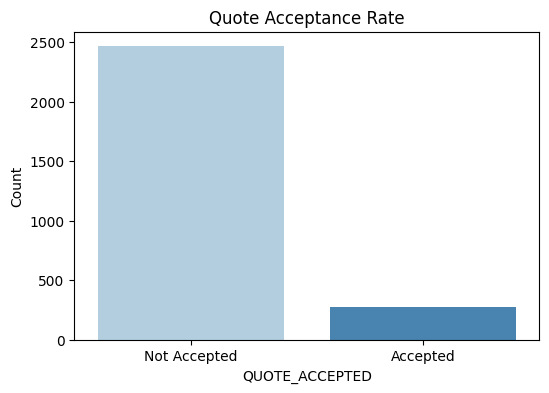

In [6]:
plt.figure(figsize=(6, 4))
sns.barplot(x=df["QUOTE_ACCEPTED"].value_counts().index, y=df["QUOTE_ACCEPTED"].value_counts().values, palette="Blues")
plt.xticks([0, 1], ["Not Accepted", "Accepted"])
plt.ylabel("Count")
plt.title("Quote Acceptance Rate")
plt.show()

As `CLIENT_ID` feature is directly related to our target yet has no predictive power, we want to eliminate it right away so that our model predictions are not clouded by it.<br>
Also, we can get rid of `VEHICLE` feature, as we already have data related to vehicle in other numerical features and information in that field might not bring any value while requiring complicated processing.

In [7]:
df = df[df.columns.difference(["CLIENT_ID", "VEHICLE"])]

We can break down `CREATED_AT` datetime feature into multiple features.

In [8]:
def engineer_date_features(df, date_column):
    # df[f"{date_column}_year"] = df[date_column].dt.year
    df[f"{date_column}_month"] = df[date_column].dt.month.astype(int)
    df[f"{date_column}_weekday"] = df[date_column].dt.weekday.astype(int)
    df[f"{date_column}_quarter"] = df[date_column].dt.quarter.astype(int)
    df[f"{date_column}_hour"] = df[date_column].dt.hour.astype(int)
    # df[f"{date_column}_minute"] = df[date_column].dt.minute.astype(int)
    df[f"{date_column}_is_weekend"] = (df[date_column].dt.weekday >= 5).astype(int)
    return df


df["CREATED_AT"] = pd.to_datetime(df["CREATED_AT"])
df = engineer_date_features(df, "CREATED_AT")

### Insights

#### Time-related

First let's analyze time-related patterns in quote acceptance.

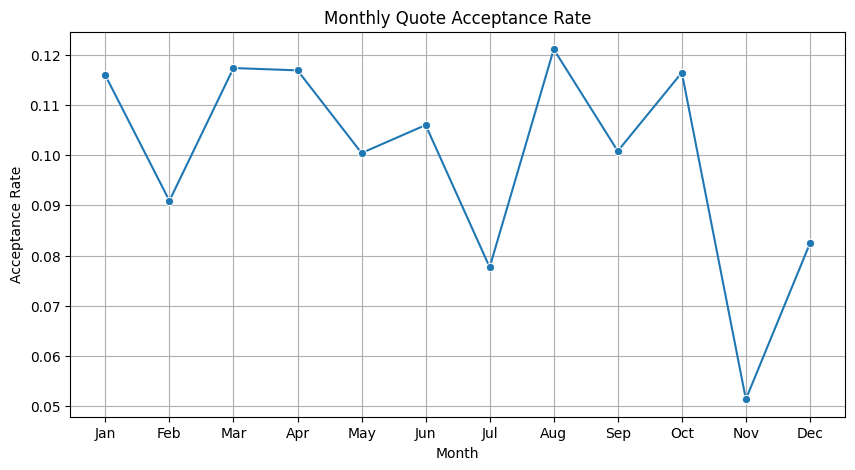

In [9]:
monthly_acceptance = df.groupby("CREATED_AT_month")["QUOTE_ACCEPTED"].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_acceptance.index, y=monthly_acceptance.values, marker="o", linestyle="-")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.xlabel("Month")
plt.ylabel("Acceptance Rate")
plt.title("Monthly Quote Acceptance Rate")
plt.grid(True)
plt.show()

This chart shows how the quote acceptance rate changes throughout the year. You can see that some months, like August and March, have a higher acceptance rate, while others, like November, drop significantly. There could be seasonal trends at play—maybe demand for taxi insurance is higher in certain months, or brokers are more effective at closing deals. The big dip in November might mean customers hold off on purchasing due to financial constraints or end-of-year expenses. It would be worth looking into what’s driving these trends to adjust strategies accordingly.

#### Broker-related


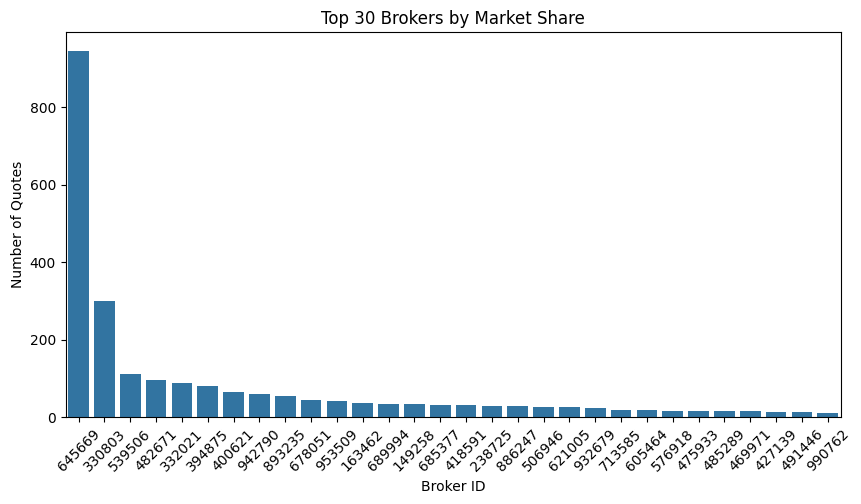

In [13]:
top_brokers = df["BROKER_ID"].value_counts().head(30)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_brokers.index, y=top_brokers.values, order=top_brokers.index)
plt.xticks(rotation=45)
plt.xlabel("Broker ID")
plt.ylabel("Number of Quotes")
plt.title("Top 30 Brokers by Market Share")
plt.show()

Here we can see top 30 brokers by market share, measured by the number of quotes they generate. One broker (ID 645609) stands out significantly, handling far more quotes than any other. The rest have much smaller shares, with a few handling moderate volumes.

This suggests that the company relies heavily on a single broker, which could be risky if that broker underperforms. It may be beneficial to diversify and encourage other brokers to generate more quotes to reduce dependency on just one. Additionally, analyzing this top broker’s conversion rate could reveal strategies that others can adopt.

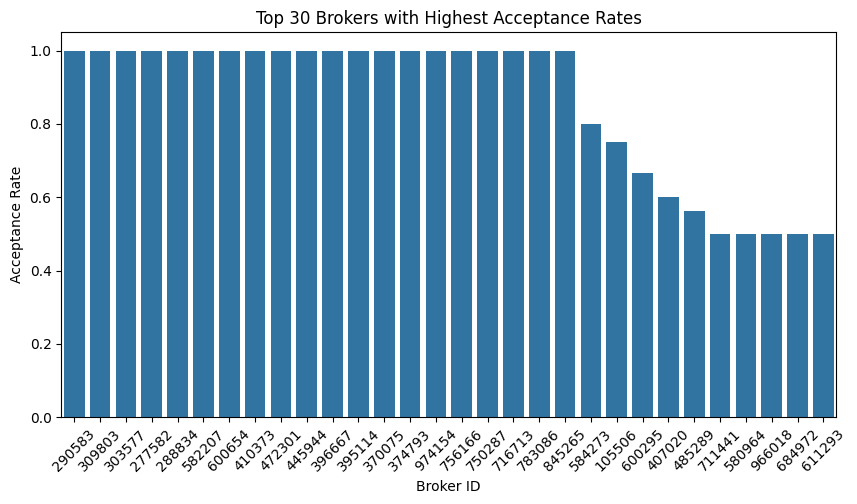

In [ ]:
broker_acceptance = df.groupby("BROKER_ID")["QUOTE_ACCEPTED"].mean().sort_values(ascending=False).head(30)

plt.figure(figsize=(10, 5))
sns.barplot(x=broker_acceptance.index, y=broker_acceptance.values, order=broker_acceptance.index)
plt.xticks(rotation=45)
plt.xlabel("Broker ID")
plt.ylabel("Acceptance Rate")
plt.title("Top 30 Brokers with Highest Acceptance Rates")
plt.show()

This chart shows the top 30 brokers with the highest acceptance rates. Several brokers have a 100% acceptance rate, meaning every quote they generate gets accepted. Others have slightly lower rates but are still performing well.

This suggests that some brokers might be more selective in generating quotes, only working with high-potential clients. It would be useful to check if these brokers handle fewer quotes overall or if they have better strategies for converting leads. The company could analyze what these top brokers are doing differently and use those insights to improve performance across all brokers.

#### Pricing factors

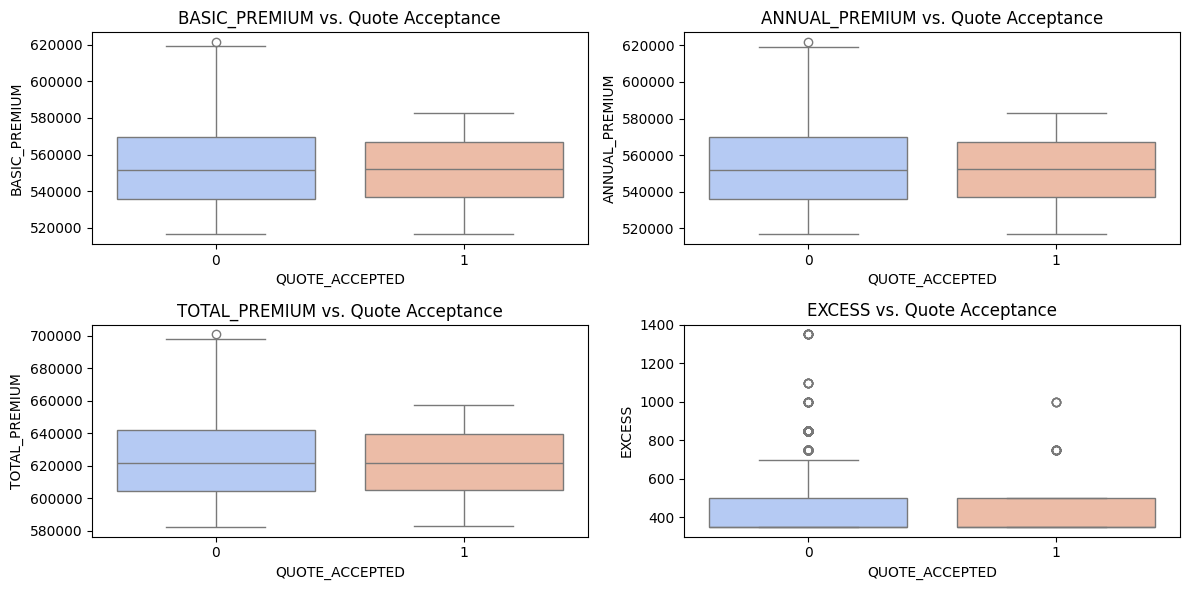

In [12]:
plt.figure(figsize=(12, 6))

pricing_features = ["BASIC_PREMIUM", "ANNUAL_PREMIUM", "TOTAL_PREMIUM", "EXCESS"]

for i, feature in enumerate(pricing_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df["QUOTE_ACCEPTED"], y=df[feature], palette="coolwarm")
    plt.title(f"{feature} vs. Quote Acceptance")

plt.tight_layout()
plt.show()

Here we can see that accepted quotes tend to have slightly lower premiums, meaning customers might be more likely to accept cheaper insurance offers. The excess amount (deductible) also seems to be lower for accepted quotes, while higher excess values appear more often in rejected ones. This suggests that both price and deductible size play a role in whether a quote gets accepted.

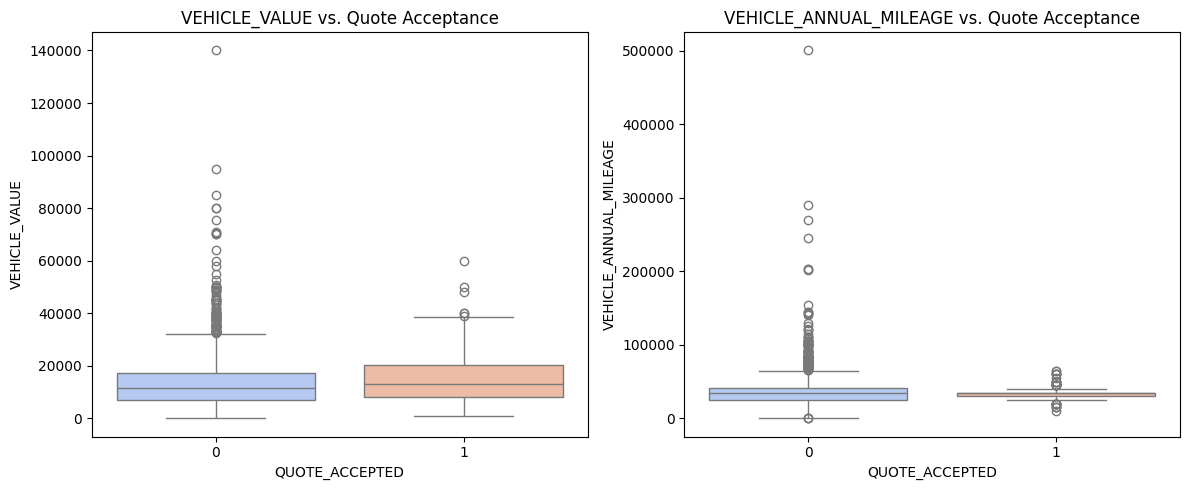

In [13]:
plt.figure(figsize=(12, 5))

vehicle_features = ["VEHICLE_VALUE", "VEHICLE_ANNUAL_MILEAGE"]

for i, feature in enumerate(vehicle_features, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df["QUOTE_ACCEPTED"], y=df[feature], palette="coolwarm")
    plt.title(f"{feature} vs. Quote Acceptance")

plt.tight_layout()
plt.show()

These boxplots compare vehicle value and annual mileage for accepted and non-accepted quotes. The distributions look similar, but there are more high-value vehicles and high-mileage outliers in non-accepted quotes. This suggests that expensive cars and vehicles with very high mileage might be less likely to get accepted, possibly due to higher insurance costs or perceived risk.

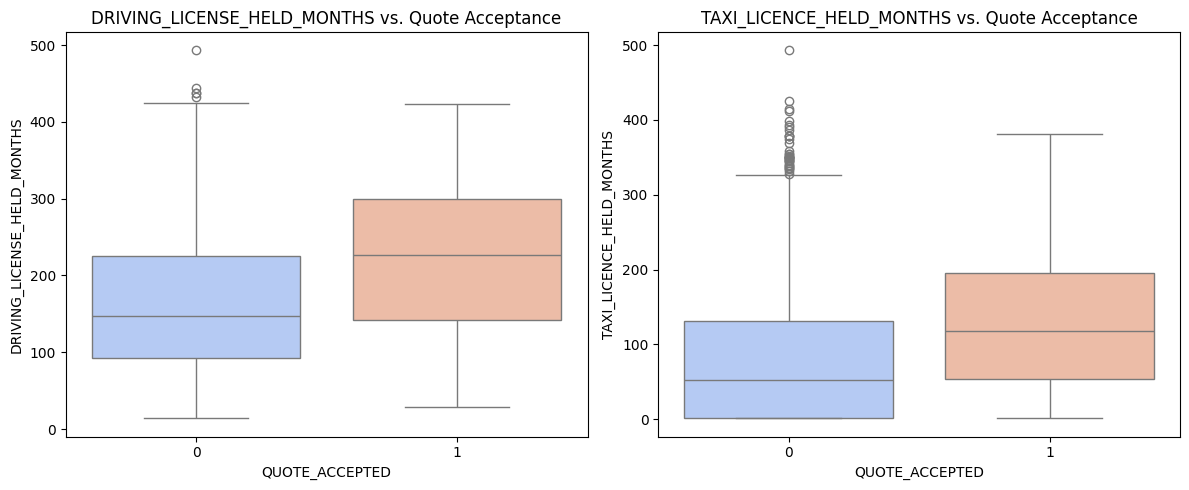

In [14]:
plt.figure(figsize=(12, 5))

experience_features = ["DRIVING_LICENSE_HELD_MONTHS", "TAXI_LICENCE_HELD_MONTHS"]

for i, feature in enumerate(experience_features, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df["QUOTE_ACCEPTED"], y=df[feature], palette="coolwarm")
    plt.title(f"{feature} vs. Quote Acceptance")

plt.tight_layout()
plt.show()

Accepted quotes tend to come from drivers with more experience. Both driving license and taxi license durations are higher for accepted quotes, meaning more experienced drivers are more likely to get their quotes approved. This makes sense since insurers may see them as lower risk compared to newer drivers.

In [15]:
df.drop(columns=["QUOTE_STATUS", "CREATED_AT"], inplace=True)

target = "QUOTE_ACCEPTED"

df_features = df[df.columns.difference([target])]
df_target = df[target]

## Feature selection + engineering

In [16]:
def categorize_variables(target, df, cat_numeric_unique_threshold=10):
    categorical_numeric = [
        var
        for var in df.columns
        if df[var].dtype != "O" and var != target and df[var].nunique() <= cat_numeric_unique_threshold
    ]
    continuous = [
        var for var in df.columns if df[var].dtype != "O" and var != target and var not in categorical_numeric
    ]
    mixed = [var for var in df.columns if var != target and pd.api.types.infer_dtype(df[var]) == "mixed"]
    categorical_object = [var for var in df.columns if var != target and df[var].dtype == "O" and var not in mixed]
    sorted_features = [target, *categorical_numeric, *continuous, *categorical_object, *mixed]
    print("Total columns: " + str(df.columns.size) + "\nColumns after sorting: " + str(len(sorted_features)))
    return categorical_numeric, continuous, mixed, categorical_object


categorical_numeric, continuous, mixed, categorical_object = categorize_variables(target, df)

Total columns: 28
Columns after sorting: 28


### Univariate feature selection

In [17]:
sel_constant = DropConstantFeatures(tol=0.998, variables=None, missing_values="raise")
sel_constant.fit(df_features)
constant_to_drop = sel_constant.features_to_drop_
constant_to_drop

[]

In [18]:
sel_duplicate = DropDuplicateFeatures(variables=None, missing_values="raise")
sel_duplicate.fit(df_features)
duplicate_to_drop = sel_duplicate.features_to_drop_
duplicate_to_drop

set()

As we can see there are no constant or duplicate features.

### Multivariate feature selection

In [19]:
#TODO cross feature correlation

### Feature engineering 

Let's split data before training.

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    df_features, df_target, test_size=0.3, random_state=0, stratify=df_target
)

One Hot Encode categorical variables

In [21]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

x_train_encoded = pd.DataFrame(
    encoder.fit_transform(x_train[categorical_object]),
    columns=encoder.get_feature_names_out(categorical_object),
    index=x_train.index,
)

x_test_encoded = pd.DataFrame(
    encoder.transform(x_test[categorical_object]),
    columns=encoder.get_feature_names_out(categorical_object),
    index=x_test.index,
)

x_train = pd.concat([x_train.drop(columns=categorical_object), x_train_encoded], axis=1)
x_test = pd.concat([x_test.drop(columns=categorical_object), x_test_encoded], axis=1)

### Target correlation feature selection

Now let's see which features are most correlated to target using boruta algorithm.

In [22]:
x_train_boruta = x_train.copy()

rf_boruta = RandomForestClassifier(
    n_jobs=-1,
    class_weight="balanced",
    max_depth=10,
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=1,
)

boruta_selector = BorutaPy(rf_boruta, n_estimators="auto", verbose=0, random_state=1)

boruta_selector.fit(x_train_boruta.values, y_train)

selected_features = x_train_boruta.columns[boruta_selector.support_].tolist()

pd.DataFrame({"Feature": x_train_boruta.columns, "Ranking": boruta_selector.ranking_}).sort_values(by="Ranking")


,Feature,Ranking
0,ADDRESS_LATITUDE,1
1,ADDRESS_LONGITUDE,1
6,CREATED_AT_hour,1
5,BROKER_ID,1
14,DRIVING_LICENSE_HELD_MONTHS,1
22,VEHICLE_VALUE,1
19,TAXI_LICENCE_HELD_MONTHS,1
17,NO_CLAIMS_BONUS_YEARS,1
21,VEHICLE_ANNUAL_MILEAGE,1
28,QUOTE_TYPE_Renewal,1


In [23]:
relevant_features = [
    "ADDRESS_LATITUDE",
    "ADDRESS_LONGITUDE",
    "CREATED_AT_hour",
    "BROKER_ID",
    "DRIVING_LICENSE_HELD_MONTHS",
    "VEHICLE_VALUE",
    "TAXI_LICENCE_HELD_MONTHS",
    "NO_CLAIMS_BONUS_YEARS",
    "VEHICLE_ANNUAL_MILEAGE",
    "QUOTE_TYPE_Renewal",
    "QUOTE_TYPE_New Business"
]

x_train = x_train[relevant_features]
x_test = x_test[relevant_features]

## Metric, model selection and hyperparameters search

### Metric selection

We would like to measure how probable it is for a given quote to be accepted. So, in essense we want our model to predict positive class with higher probability. Perfect metric to measure exactly that is `Brier Score`. Brier Score measures mean squared error, but for the probabilities, meaning the lower it is the more accurate are the predictions of probabilities.

We can also use `ROC AUC` as well as `Log Loss` as auxiliary metrics to see how well the model differentiates between positive and negative classes and how confident it is in its predictions, respectively.

### Base model performance
Now let's see how basic Random Forest model performs on our data.

In [77]:
def get_base_model():
    return RandomForestClassifier(
        n_jobs=-1,
        max_depth=10,
        n_estimators=100,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=1,
    )

model = get_base_model()

model.fit(x_train, y_train)

y_test_pred_base = model.predict_proba(x_test)[:, 1]
y_test_pred_base_class = model.predict(x_test)

brier_score_base = brier_score_loss(y_test, y_test_pred_base)
roc_auc_base = roc_auc_score(y_test, y_test_pred_base)
log_loss_score_base = log_loss(y_test, y_test_pred_base)

print(f"Brier Score: {brier_score_base:.2f}")
print(f"Log Loss: {log_loss_score_base:.2f}")
print(f"ROC AUC: {roc_auc_base:.2f}")


Brier Score: 0.07
Log Loss: 0.24
ROC AUC: 0.86


### SMOTE vs SMOTEEN

As we have chosen our most relevant features and metrics, now we can verify if addressing target imbalance with SMOTE or SMOTEEN techniques helps to improve our metrics.<br>
We'll take RandomForestClassifier as a base model.

In [74]:
log_loss_scorer = make_scorer(log_loss, needs_proba=True, greater_is_better=False)
brier_score_scorer = make_scorer(brier_score_loss, needs_proba=True, greater_is_better=False)
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, greater_is_better=True)

def train_and_evaluate(x_train, y_train, use_smote=None):
    base_model = get_base_model()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_pred_proba = np.zeros_like(y_train, dtype=float)

    for train_idx, test_idx in cv.split(x_train, y_train):
        x_train_fold, x_val_fold = x_train.iloc[train_idx], x_train.iloc[test_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

        model = clone(base_model)

        if use_smote == "smoteen":
            sampler = SMOTEENN(random_state=42)
        elif use_smote == "smote":
            sampler = SMOTE(random_state=42)
        else:
            sampler = None

        if sampler:
            x_train_fold, y_train_fold = sampler.fit_resample(x_train_fold, y_train_fold)

        model.fit(x_train_fold, y_train_fold)
        y_pred_proba[test_idx] = model.predict_proba(x_val_fold)[:, 1]

    metrics = {
        "brier_score": brier_score_loss(y_train, y_pred_proba),
        "log_loss": log_loss(y_train, y_pred_proba),
        "roc_auc": roc_auc_score(y_train, y_pred_proba),
    }

    return metrics

baseline_metrics = train_and_evaluate(x_train, y_train, use_smote=False)
smote_metrics = train_and_evaluate(x_train, y_train, use_smote="smote")
smoteen_metrics = train_and_evaluate(x_train, y_train, use_smote="smoteen")

pd.DataFrame([baseline_metrics, smote_metrics, smoteen_metrics], index=["No SMOTE", "With SMOTE", "With SMOTEENN"])

,brier_score,log_loss,roc_auc
No SMOTE,0.076419,0.259784,0.820230
With SMOTE,0.105853,0.331320,0.829370
With SMOTEENN,0.126796,0.382380,0.831106


We can see that `ROC AUC` increases in case of both sampling techniques, although insignificantly, yet both `Log Loss` and `Brier score` start increasing, which means both confidence in probability predictions and accuracy drop.<br>
Therefore, we can confidently avoid sampling approaches.

### Hyperparameter tuning
Now let's select best model as well as best hyperparameters for it. Our best model, hyperparameters and metrics will be logged to MLFLow experiment tracker.

In [78]:
N_JOBS = multiprocessing.cpu_count()

def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["logit", "RF", "GBM", "XGB"])

    if classifier_name == "logit":
        logit_penalty = trial.suggest_categorical("logit_penalty", ["l1", "l2"])
        logit_c = trial.suggest_float("logit_C", 0.001, 10)
        model = LogisticRegression(penalty=logit_penalty, C=logit_c, solver="saga", max_iter=1000)

    elif classifier_name == "RF":
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
        rf_criterion = trial.suggest_categorical("rf_criterion", ["gini", "entropy"])
        rf_max_depth = trial.suggest_int("rf_max_depth", 1, 10)
        rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.01, 1)
        model = RandomForestClassifier(
            class_weight="balanced",
            n_estimators=rf_n_estimators,
            criterion=rf_criterion,
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
        )

    elif classifier_name == "GBM":
        gbm_n_estimators = trial.suggest_int("gbm_n_estimators", 100, 1000)
        gbm_criterion = trial.suggest_categorical("gbm_criterion", ["friedman_mse"])
        gbm_max_depth = trial.suggest_int("gbm_max_depth", 1, 10)
        gbm_min_samples_split = trial.suggest_float("gbm_min_samples_split", 0.01, 1)
        model = GradientBoostingClassifier(
            n_estimators=gbm_n_estimators,
            criterion=gbm_criterion,
            max_depth=gbm_max_depth,
            min_samples_split=gbm_min_samples_split,
        )

    elif classifier_name == "XGB":
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 100, 1000)
        xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.1)
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 8)
        xgb_min_child_weight = trial.suggest_int("xgb_min_child_weight", 3, 8)
        xgb_colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.6, 0.9)
        xgb_reg_lambda = trial.suggest_float("xgb_reg_lambda", 0.01, 10.0)
        xgb_reg_alpha = trial.suggest_float("xgb_reg_alpha", 0.1, 5.0)

        model = XGBClassifier(
            n_estimators=xgb_n_estimators,
            learning_rate=xgb_learning_rate,
            max_depth=xgb_max_depth,
            min_child_weight=xgb_min_child_weight,
            colsample_bytree=xgb_colsample_bytree,
            reg_lambda=xgb_reg_lambda,
            reg_alpha=xgb_reg_alpha,
            tree_method="gpu_hist",
            gpu_id=0
        )


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_pred_proba = cross_val_predict(model, x_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

    brier_score = brier_score_loss(y_train, y_pred_proba)
    log_loss_score = log_loss(y_train, y_pred_proba)
    roc_auc = roc_auc_score(y_train, y_pred_proba)

    return brier_score, log_loss_score, roc_auc

def best_params_model(best_trial):
    best_params = best_trial.params
    classifier = best_params.pop("classifier", None)
    clean_params = {key.split("_", 1)[-1]: value for key, value in best_params.items()}

    model_mapping = {
        "logit": LogisticRegression,
        "GBM": GradientBoostingClassifier,
        "XGB": XGBClassifier,
        "RF": RandomForestClassifier,
    }

    model_class = model_mapping.get(classifier, None)

    if model_class is None:
        raise ValueError(f"Unknown classifier type: {classifier}")

    model = model_class(**clean_params)

    start_mlflow_server()
    mlflow.set_experiment('taxi-insurance-quotes')
    with mlflow.start_run():
        mlflow.log_param("classifier", classifier)
        mlflow.log_params(clean_params)
        mlflow.sklearn.log_model(model, "best_model")
        mlflow.log_metric("Brier Score", best_trial.values[0])
        mlflow.log_metric("Log Loss", best_trial.values[1])
        mlflow.log_metric("ROC-AUC", best_trial.values[2])
        print(f"Model {classifier} with best parameters logged to MLflow.")

    return model

study = optuna.create_study(directions=["minimize","minimize","maximize"])
study.optimize(objective, n_trials=100, n_jobs=N_JOBS)

best_trial = sorted(study.best_trials, key=lambda t: t.values[0], reverse=True)[0]

best_model = best_params_model(best_trial)

print(f"Best study params: {best_trial.params}")
print(f"Best study metric value: {best_trial.values}")

[I 2025-02-17 21:49:29,294] A new study created in memory with name: no-name-8aa9d822-dd4d-4337-8fc9-b655fde743e0
[I 2025-02-17 21:49:32,623] Trial 0 finished with values: [0.1737461918508396, 0.5235462234890442, 0.8172861755650671] and parameters: {'classifier': 'RF', 'rf_n_estimators': 456, 'rf_criterion': 'gini', 'rf_max_depth': 10, 'rf_min_samples_split': 0.3493879947849658}.
[I 2025-02-17 21:49:32,664] Trial 2 finished with values: [0.0947826359631178, 0.3423059063276703, 0.5087482165652925] and parameters: {'classifier': 'logit', 'logit_penalty': 'l2', 'logit_C': 2.9037763850974905}.
[I 2025-02-17 21:49:33,982] Trial 19 finished with values: [0.08819646642921695, 0.31572363268363474, 0.8214642937598559] and parameters: {'classifier': 'GBM', 'gbm_n_estimators': 421, 'gbm_criterion': 'friedman_mse', 'gbm_max_depth': 7, 'gbm_min_samples_split': 0.4029195462133453}.
[I 2025-02-17 21:49:34,876] Trial 21 finished with values: [0.24977116125800314, 0.6926895029334652, 0.5] and parameter

MLflow server is already running on port 8080


2025/02/17 21:52:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/02/17 21:52:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model XGB with best parameters logged to MLflow.
🏃 View run youthful-bear-565 at: http://127.0.0.1:8080/#/experiments/692560883904913210/runs/9d81e7d59b864e11b810f44a4fa1e144
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/692560883904913210
Best study params: {'xgb_n_estimators': 362, 'xgb_learning_rate': 0.08882901642683057, 'xgb_max_depth': 3, 'xgb_min_child_weight': 4, 'xgb_colsample_bytree': 0.6054891716917901, 'xgb_reg_lambda': 7.453171578274321, 'xgb_reg_alpha': 4.130017772267121}
Best study metric value: [0.07416706499598293, 0.2471898162278169, 0.8513028459863333]


In [82]:
best_model.fit(x_train, y_train)

y_test_pred = best_model.predict(x_test)
y_test_pred_proba = best_model.predict_proba(x_test)[: ,1]

brier_score = brier_score_loss(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)
log_loss_score = log_loss(y_test, y_test_pred_proba)

classification_rep = classification_report(y_test, y_test_pred)
classification_rep_base = classification_report(y_test, y_test_pred_base_class)


print(f"_______BEST MODEL SCORES({type(best_model).__name__})_______")
print(f"Brier Score: {brier_score:.3f}")
print(f"Log Loss: {log_loss_score:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Classification Report:\n {classification_rep}")

print(f"\n\n_______BASE MODEL SCORES({type(get_base_model()).__name__})_______")
print(f"Brier Score: {brier_score_base:.3f}")
print(f"Log Loss: {log_loss_score_base:.3f}")
print(f"ROC AUC: {roc_auc_base:.3f}")
print(f"Classification Report:\n {classification_rep_base}")


_______BEST MODEL SCORES(XGBClassifier)_______
Brier Score: 0.066
Log Loss: 0.222
ROC AUC: 0.882
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       740
           1       0.65      0.32      0.43        82

    accuracy                           0.91       822
   macro avg       0.79      0.65      0.69       822
weighted avg       0.90      0.91      0.90       822



_______BASE MODEL SCORES(RandomForestClassifier)_______
Brier Score: 0.071
Log Loss: 0.243
ROC AUC: 0.859
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       740
           1       0.61      0.28      0.38        82

    accuracy                           0.91       822
   macro avg       0.77      0.63      0.67       822
weighted avg       0.89      0.91      0.89       822



## Summary 

After benchmarking optimized Gradient Boosting model against the Random Forest baseline, it is evident that hyperparameter tuning improved the model, although not by much.

The most relevant `Brier Score` metric decreased together with `Log Loss`, meaning model probability prediction accuracy and confidence increased. Also, it distinguishes better between positive and negative cases due to higher `ROC AUC`.

The gains are not that spectacular, so to improve the model further we could try:
- Extending hyperparameter tuning with a longer search time to explore more optimal configurations. 
- Feature engineering, such as creating new interaction features. 
- Add more data to training.

Limitation of my solution is that it still struggles with low scores, so further investigation of causes is needed.

## Model export

In [27]:
os.makedirs("app/target", exist_ok=True)
filepath = os.path.join("app/target", "model.pkl")
joblib.dump(best_model, filepath)
print(f"Model saved as {filepath}")


Model saved as app/target\model.pkl


## Production model usage

The model is already saved to a binary file and also can be used on a FastAPI endpoint after training. See `README` for details on serving and Dockerizing the model.<br> 
You can use the created docker image in the cloud of your choice. What needs to be added to app are monitoring, data drift detection and retraining so that model responds properly to chages in user data.